# Synthetic drifter trajectories exponentially autocorrelated velocities

We generate synthetic exponentially autocorrelated velocity timeseries.
Displacement and acceleration timeseries are derived.

We verify pure exponentially decorrelated timeseries are not differentiable and lead to white noise acceleration.
A modification leading to differentiable solutions is used and consists in (multi-layer) embeded Ornstein–Uhlenbeck (OU) processes [Sawford 1991, Viggiano et al. 2020].
All processes are assumed Gaussian and could be extended to more general distributions [Viggiano et al. 2020].

References:

- B. Viggiano, J. Friedrich, R. Volk, M. Bourgoin, R. B. Cal, and L. Chevillard. Modelling lagrangian velocity and acceleration in turbulent flows as infinitely differentiable stochastic processes. Journal of Fluid Mechanics, 900, 2020.
- B. Sawford. Reynolds number effects in lagrangian stochastic models of turbulent dispersion. Physics of Fluids A: Fluid Dynamics, 3(6):1577–1586, 1991.


In [1]:
import os
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

---

# Embedded OU processes: Viggiano et al. 2020

We generate timeseries corresponding to their equations (2.14-2.18).

In [2]:
# decorrelation timescales
T = [5,10,20,40]
t = (1000, 1 / 24) # timeline: 1000 days with hourly sampling
N = 10 # number of random draws

tau_eta = 0.5 # short timescale
n_layers = 5 # number of layers

In [3]:
root_dir ='/Users/mdemol/code/PhD/GDP/synthetics_trajectories'
path = os.path.join(root_dir, "synthetic_traj_ou.zarr")
ds = xr.open_zarr(path, decode_timedelta=False)
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 10, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables:
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    uu         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    x          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    xx         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>

In [6]:
d ={'a':'b'}
len(d)

1

## Plotting functions

In [48]:
colors = get_cmap_colors(ds.T.size, cmap="plasma")
plt.rc('axes', prop_cycle=cycler(color=colors))

def plot_timeseries(ds, tmax=100, suffixes_ls ={'':'solid'}, suffixes_leg={'':''},  title = ''):

    fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=True)

    ax = axes[0]
    for suf in suffixes_ls :         
        ds["x"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf]);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Position x")


    ax = axes[1]
    for suf in suffixes_ls :         
        ds["u"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf]);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Velocity v")

    ax = axes[2]
    for suf in suffixes_ls :         
        ds["a"+suf].where(ds.time < tmax).plot.line(x="time", ax=ax, ls=suffixes_ls[suf]);
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    ax.set_ylabel("Acceleration a")
    
    if len(suffixes_ls)>1 : 
        leg = ''
        for suf in suffixes_leg: 
            leg += suffixes_ls [suf] +' : ' + suffixes_leg[suf]+'\n'
        fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

    fig.tight_layout(rect=[0,0.05,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    return fig, axes

def plot_autocorrelations(ds, tau_max=100, suffixes_ls ={'':'solid'}, suffixes_leg={'':''}, title=''):

    fig, axes = plt.subplots(1,3, figsize=(15,4), sharex=True)

    ax = axes[0]
    for suf in suffixes_ls : 
        (ds["xx"+suf]/ds["xx"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf]);  
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")


    ax = axes[1]
    for suf in suffixes_ls : 
        (ds["uu"+suf]/ds["uu"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf]);  
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")

    ax = axes[2]
    for suf in suffixes_ls : 
        (ds["aa"+suf]/ds["aa"+suf].sel(lags=0)).where(ds.lags < tau_max).plot.line(x="lags", ax=ax, ls = suffixes_ls[suf]);  
    ax.grid()
    ax.set_title("")
    ax.set_xlabel("")
    
    if len(suffixes_ls)>1 : 
        leg = ''
        for suf in suffixes_leg: 
            leg += suffixes_ls [suf] +' : ' + suffixes_leg[suf]+'\n'
        fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

  
    fig.tight_layout(rect=[0,0.05,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    return fig, axes

def plot_spectraloglog(ds, suffixes_ls ={'':'solid'}, suffixes_leg={'':''}, title='') : 
    fig, axs = plt.subplots(1,2, figsize=(15,6), sharex=True, sharey=True)

    for _T, c in zip(ds.T, colors):
        ax=axs[0]
        i=True
        for suf in suffixes_ls :  
            _E = ds['Eu'+suf].mean("draw")
            if i :
                (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                i=False
            else : 
                (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.grid()
        ax.set_title('')
                
    
        ax=axs[1]
        for suf in suffixes_ls :  
            _E = ds['Ea'+suf].mean("draw")
            if i :
                (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls =suffixes_ls[suf], label=f"T={float(_T):.0f}d")
                i=False
            else : 
                (_E/_E.sel(freq_time=0)).sel(T=_T).plot(x="freq_time", ax=ax, color=c, ls = suffixes_ls[suf])
    
        ax.set_xscale("log")
        ax.set_yscale("log")
        
        ax.set_title('')
        #Eu.mean("draw").sel(tau_eta=1).plot(x="freq_time", ax=ax, hue="T")
        
    if len(suffixes_ls)>1 : 
        leg = ''
        for suf in suffixes_leg: 
            leg += suffixes_ls [suf] +' : ' + suffixes_leg[suf]+'\n'
        fig.text(0.5, -0.01, leg, ha="center")#, fontsize=18)#, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

   
    axs[0].grid()
    axs[1].grid()
    fig.legend()
    fig.tight_layout(rect=[0,0,1,0.95])#left, bottom, right, top (default is 0,0,1,1)
    fig.suptitle(title)
    
    return fig, ax

## Illustration for synthetic trajectories

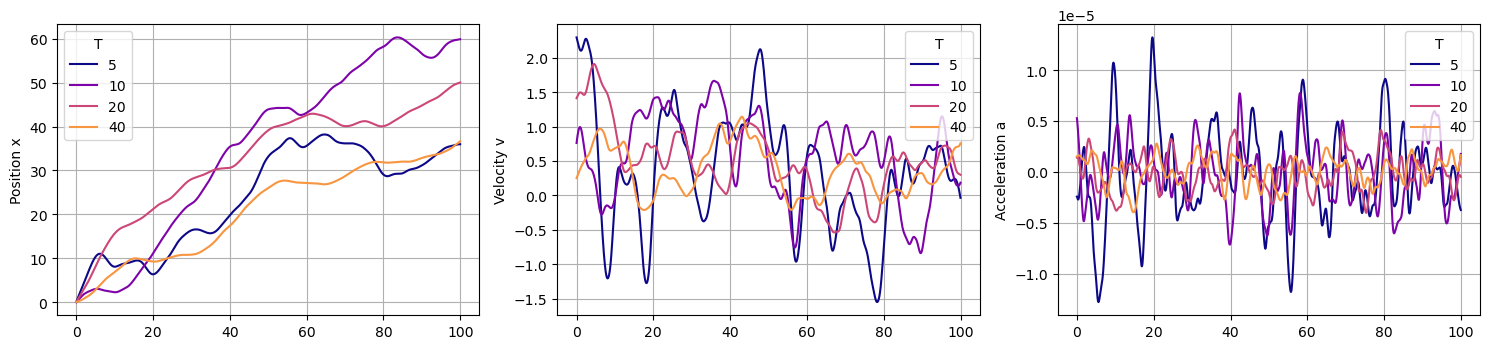

In [9]:
plot_timeseries(ds.isel(draw=2));

(<Figure size 1500x400 with 3 Axes>,
 array([<AxesSubplot: ylabel='xx'>, <AxesSubplot: ylabel='uu'>,
        <AxesSubplot: ylabel='aa'>], dtype=object))

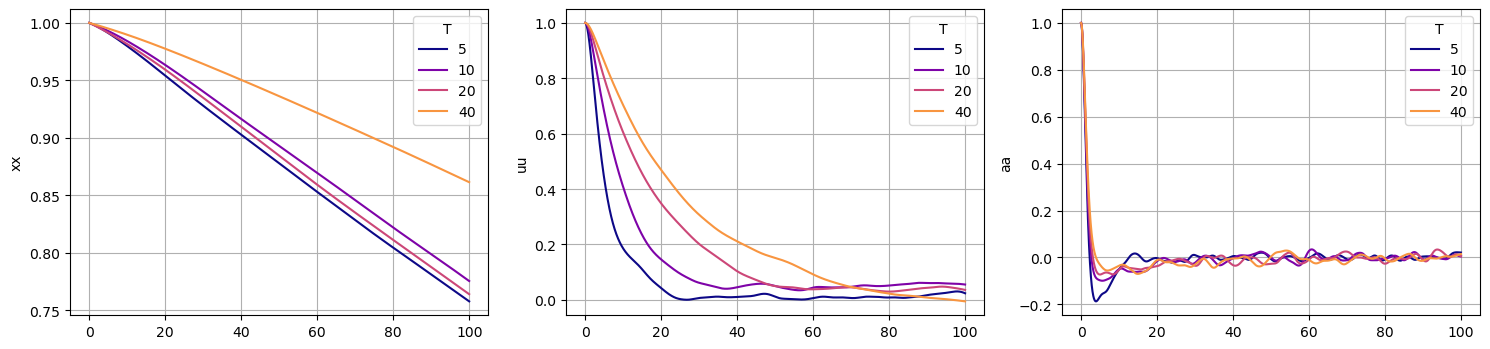

In [10]:
plot_autocorrelations(ds.mean("draw"), tau_max=100)

(<Figure size 1500x600 with 2 Axes>,
 <AxesSubplot: xlabel='freq_time', ylabel='Ea'>)

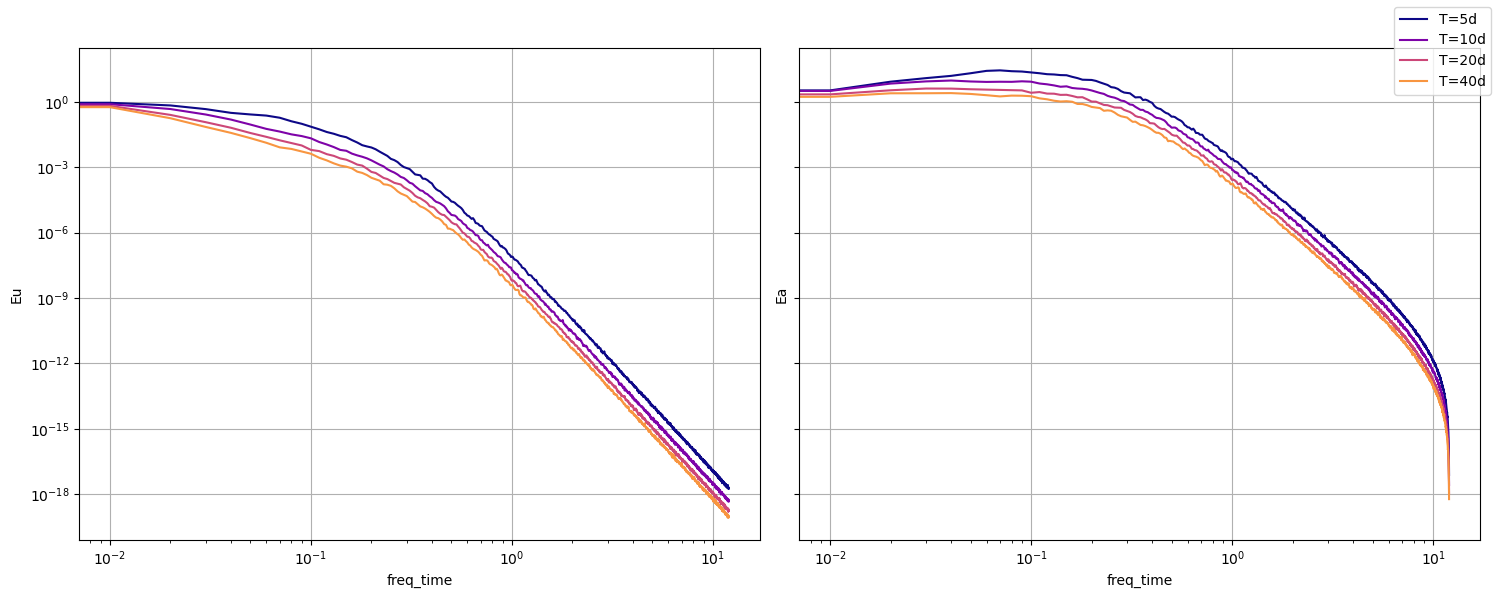

In [11]:
plot_spectraloglog(ds)

---

# Adding white noise to velocity

Generating white noise to add to position or velocity

In [12]:
noise_std = 1.

# first method: common noise realization 
#from numpy.random import randn
#ds["noise_c"] = ("time", randn(ds.time.size)*noise_std)

# second method: independent noise realizations
# scale represents the noise 
ds["noise_i"] = ts.normal(t, draws=N)*noise_std

In [35]:
def add_noised_vel_var(ds, noise, suffix, std_noise):
    
    ds['u'+suffix]=ds['u']+ds[noise]*std_noise
    ds["x"+suffix] = ds['u'+suffix].cumulative_integrate("time") #.assign_attrs(units="m")
    ds["a"+ suffix] = ds['u'+suffix].differentiate("time").assign_attrs(units="m/s^2") /86400  # rescale in m/s
    ds['u'+suffix].attrs = {'description': 'u +'+ noise +f'{std_noise}m/s', 'noise_std':std_noise}
    ds['x'+suffix].attrs = {'description':'x from cumulative integration of u +'+ noise +f'{std_noise}m/s'}
    ds['a'+suffix].attrs = {'description':'a from differentiation of u +'+ noise +f'{std_noise}m/s'}
    
    # compute autocorrelations
    ds['xx'+suffix] = sigp.correlate(ds["x"+suffix], ds["x"+suffix]).rename("xx"+suffix).persist()
    ds['uu'+suffix] = sigp.correlate(ds['u'+suffix], ds['u'+suffix]).rename("uu"+suffix).persist()
    ds['aa'+suffix] = sigp.correlate(ds["a"+ suffix], ds["a"+ suffix]).rename("aa"+suffix).persist()
    
    # compute spectra
    ds['Ex'+suffix] = sigp.spectrum_welch(ds["x"+suffix], T=100)[0]
    ds['Eu'+suffix] = sigp.spectrum_welch(ds['u'+suffix], T=100)[0]
    ds['Ea'+suffix]= sigp.spectrum_welch(ds["a"+ suffix], T=100)[0]

def add_noised_pos_var(ds, noise, suffix, std_noise):
    
    ds['x'+suffix]=ds['x']+ds[noise]*std_noise
    ds["u"+suffix] = ds['x'+suffix].differentiate("time").assign_attrs(units="m/s") /86400  # rescale in m/s
    ds["a"+ suffix] = ds['u'+suffix].differentiate("time").assign_attrs(units="m/s^2") /86400  # rescale in m/s
    
    ds['x'+suffix].attrs = {'description': 'x +'+ noise +f'{std_noise}m', 'noise_std':std_noise}
    ds['u'+suffix].attrs = {'description':'x from differention of x +'+ noise +f'{std_noise}m/s'}
    ds['a'+suffix].attrs = {'description':'a from double differentiation of x +'+ noise +f'{std_noise}m/s'}
    
    # compute autocorrelations
    ds['xx'+suffix] = sigp.correlate(ds["x"+suffix], ds["x"+suffix]).rename("xx"+suffix).persist()
    ds['uu'+suffix] = sigp.correlate(ds['u'+suffix], ds['u'+suffix]).rename("uu"+suffix).persist()
    ds['aa'+suffix] = sigp.correlate(ds["a"+ suffix], ds["a"+ suffix]).rename("aa"+suffix).persist()
    
    # compute spectra
    Ex, omega = sigp.spectrum_welch(ds["x"+suffix], T=100)
    Eu, omega = sigp.spectrum_welch(ds['u'+suffix], T=100)
    Ea, omega = sigp.spectrum_welch(ds['a'+suffix], T=100)
    ds['Ex'+suffix] = Ex
    ds['Eu'+suffix] = Eu
    ds['Ea'+suffix]= Ea

    return ds

In [29]:
std_noise_x =[1,2,0.5]
std_noise_u =[1,2,0.5]
ls_list = ['solid','loosely dotted','loosely dashed','dashdot', ]
suffixes_x = [f'_nx{n}'.replace('.','') for n in std_noise_x]
suffixes_u = [f'_nu{n}'.replace('.','') for n in std_noise_u]

In [36]:
for i in range(len(std_noise_x)) : 
    add_noised_pos_var(ds, 'noise_i', suffixes_x[i], std_noise_x[i])
for i in len(std_noise_u) : 
    add_noised_vel_var(ds, 'noise_i', suffixes_u, std_noise_u)

In [41]:
ds

<xarray.Dataset>
Dimensions:    (T: 4, draw: 10, freq_time: 2400, time: 24000, lags: 24000)
Coordinates:
  * T          (T) int64 5 10 20 40
  * draw       (draw) int64 0 1 2 3 4 5 6 7 8 9
  * freq_time  (freq_time) float64 -12.0 -11.99 -11.98 ... 11.97 11.98 11.99
  * lags       (lags) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
  * time       (time) float64 0.0 0.04167 0.08333 0.125 ... 999.9 999.9 1e+03
Data variables: (12/64)
    Ea         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ex         (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    a          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    aa         (T, draw, lags) float64 dask.array<chunksize=(4, 10, 5000), meta=np.ndarray>
    u          (T, time, draw) float64 dask.array<chunksize=(4, 5000, 10), meta=np.ndarray>
    ...         ...
    xx_nx05    (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    uu_nx05    (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    aa_nx05    (T, draw, lags) float64 dask.array<chunksize=(4, 10, 24000), meta=np.ndarray>
    Ex_nx05    (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Eu_nx05    (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>
    Ea_nx05    (T, draw, freq_time) float64 dask.array<chunksize=(4, 10, 2400), meta=np.ndarray>

In [ ]:
suffixes_ls = {'': 'solid', '_nx05':'dashed'}
for  
suffixes_ls[suffixes

## Comparison synthetic/white noise on position/white noise on velocity

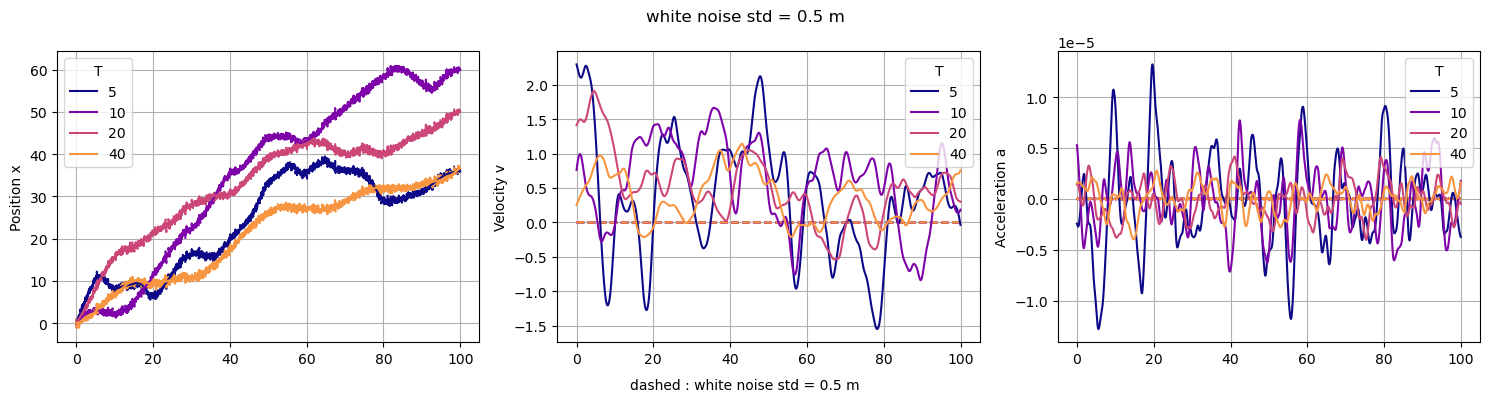

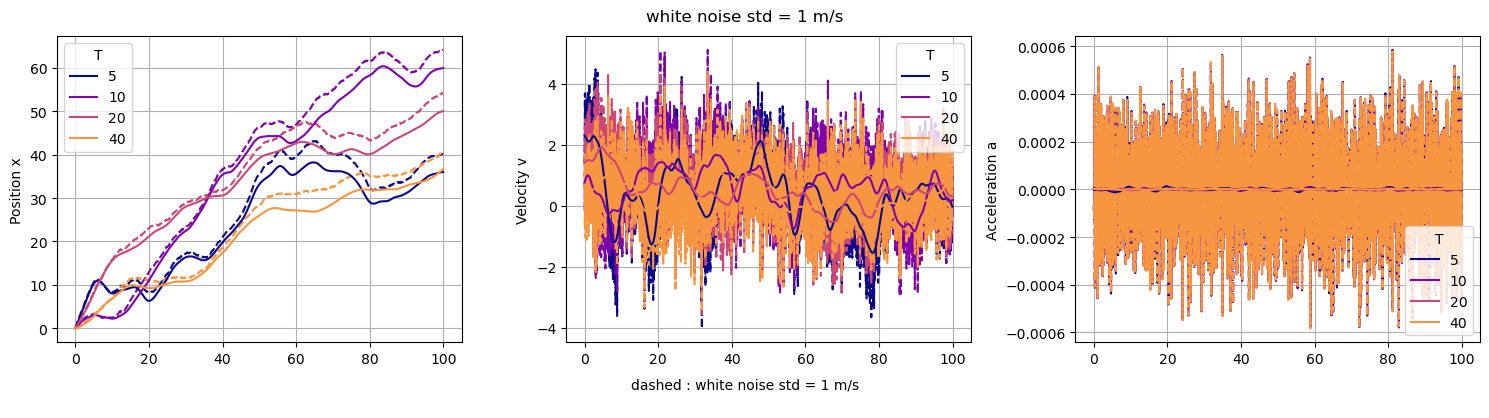

In [52]:
plot_timeseries(ds.isel(draw=2), suffixes_ls = {'_nx05':'dashed', '': 'solid', }, suffixes_leg = { '_nx05':'white noise std = 0.5 m'}, title ='white noise std = 0.5 m');
plot_timeseries(ds.isel(draw=2), suffixes_ls = {'_nv1':'dashed', '': 'solid', }, suffixes_leg = { '_nv1': 'white noise std = 1 m/s'}, title = 'white noise std = 1 m/s');

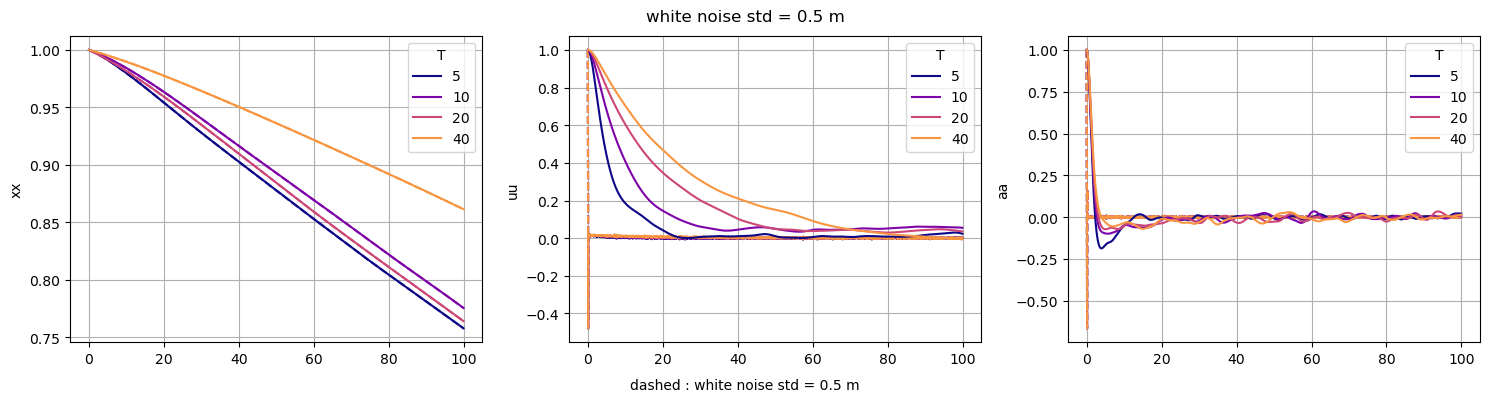

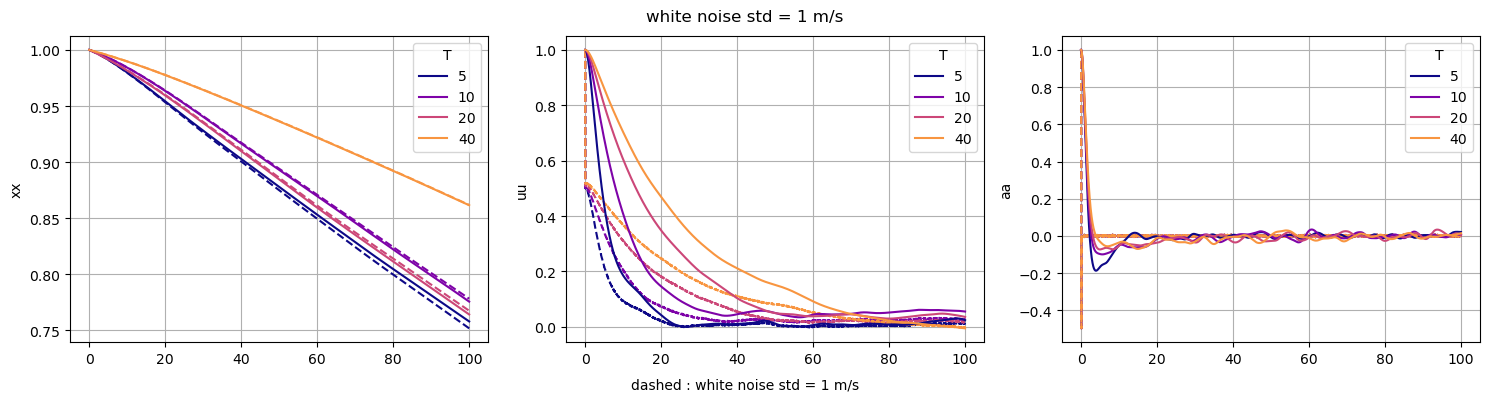

In [51]:
plot_autocorrelations(ds.mean("draw"), tau_max=100, 
                      suffixes_ls = {'_nx05':'dashed', '': 'solid', }, suffixes_leg = { '_nx05':'white noise std = 0.5 m'}, title = 'white noise std = 0.5 m');
plot_autocorrelations(ds.mean("draw"), tau_max=100,
                      suffixes_ls = {'_nv1':'dashed', '': 'solid', }, suffixes_leg = { '_nv1': 'white noise std = 1 m/s'}, title = 'white noise std = 1 m/s');

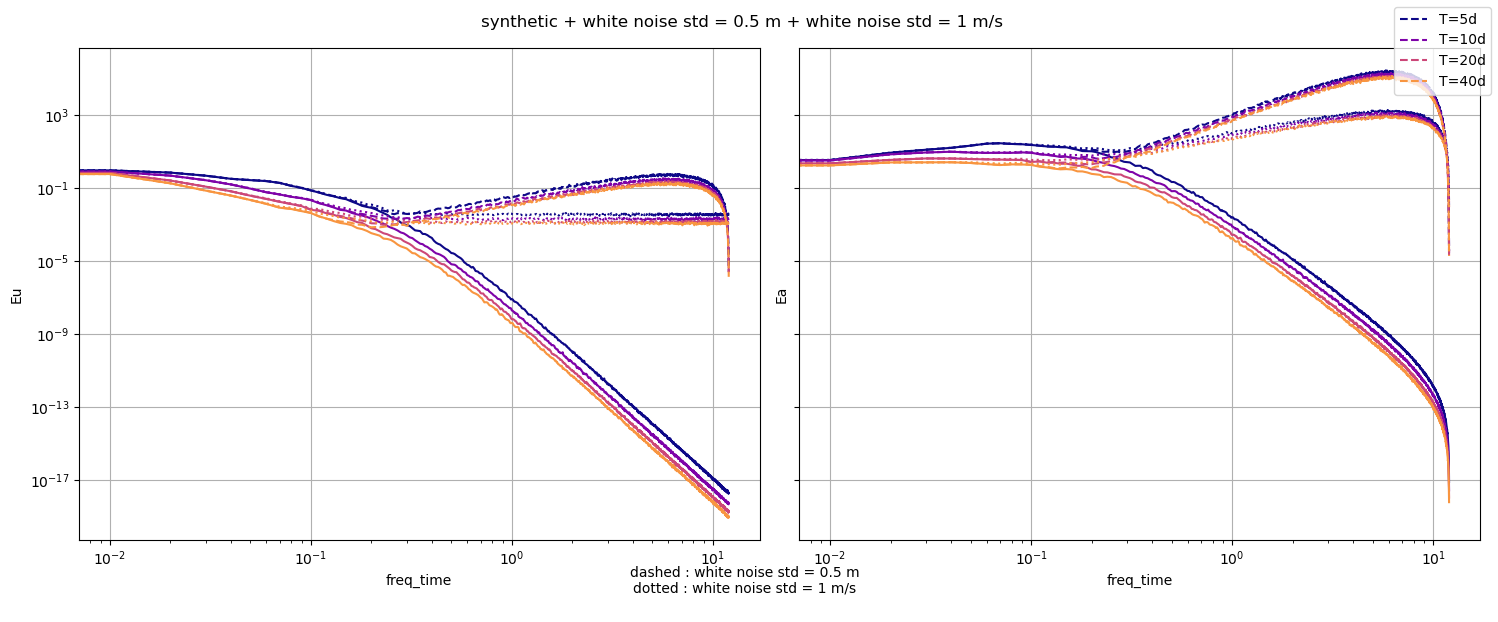

In [53]:
plot_spectraloglog(ds, 
                   suffixes_ls = {'_nx05':'dashed','_nv1':'dotted', '': 'solid', },
                   suffixes_leg = { '_nx05':'white noise std = 0.5 m','_nv1': 'white noise std = 1 m/s'},
                   title = 'synthetic + white noise std = 0.5 m + white noise std = 1 m/s ');


## Impact of the white noise std
### On position 

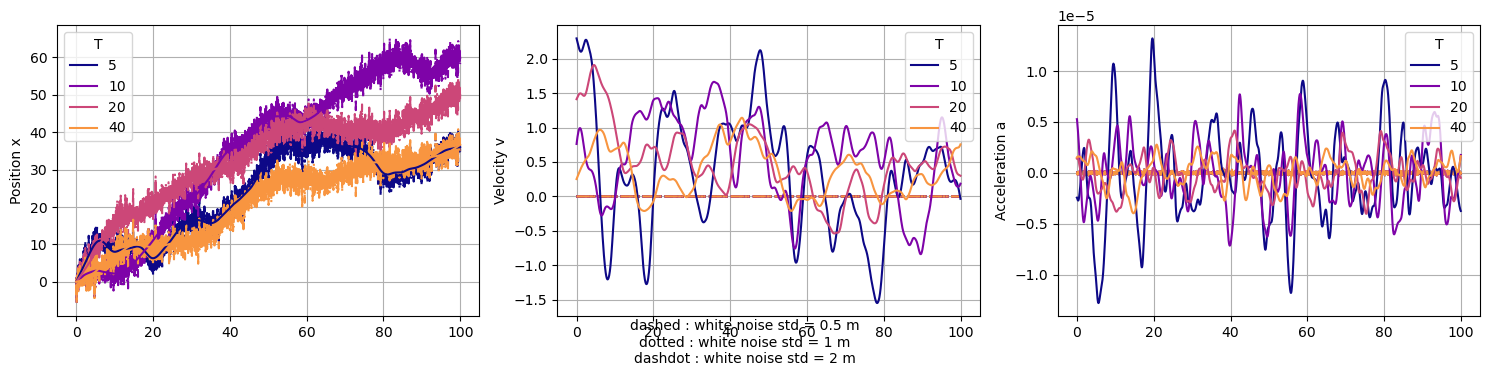

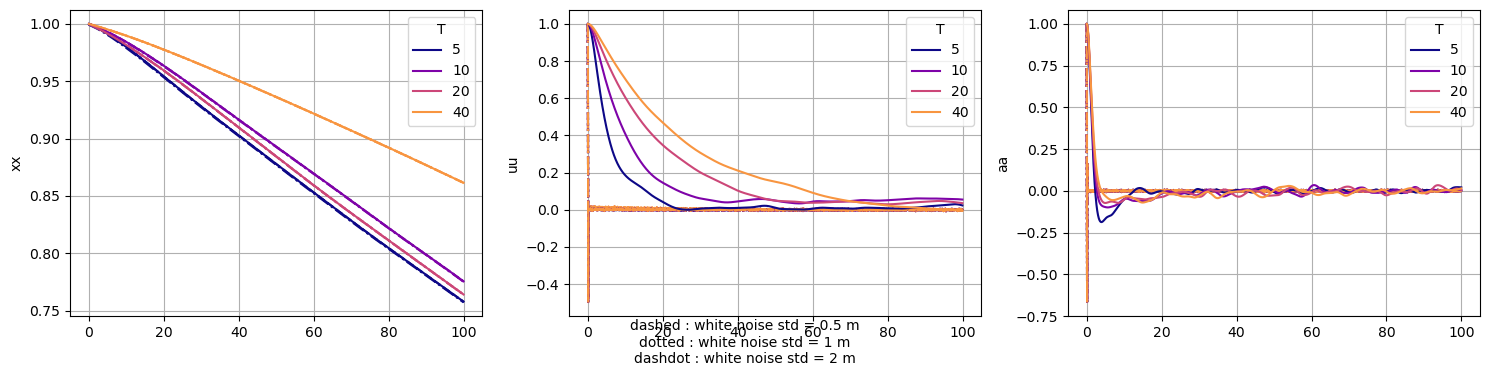

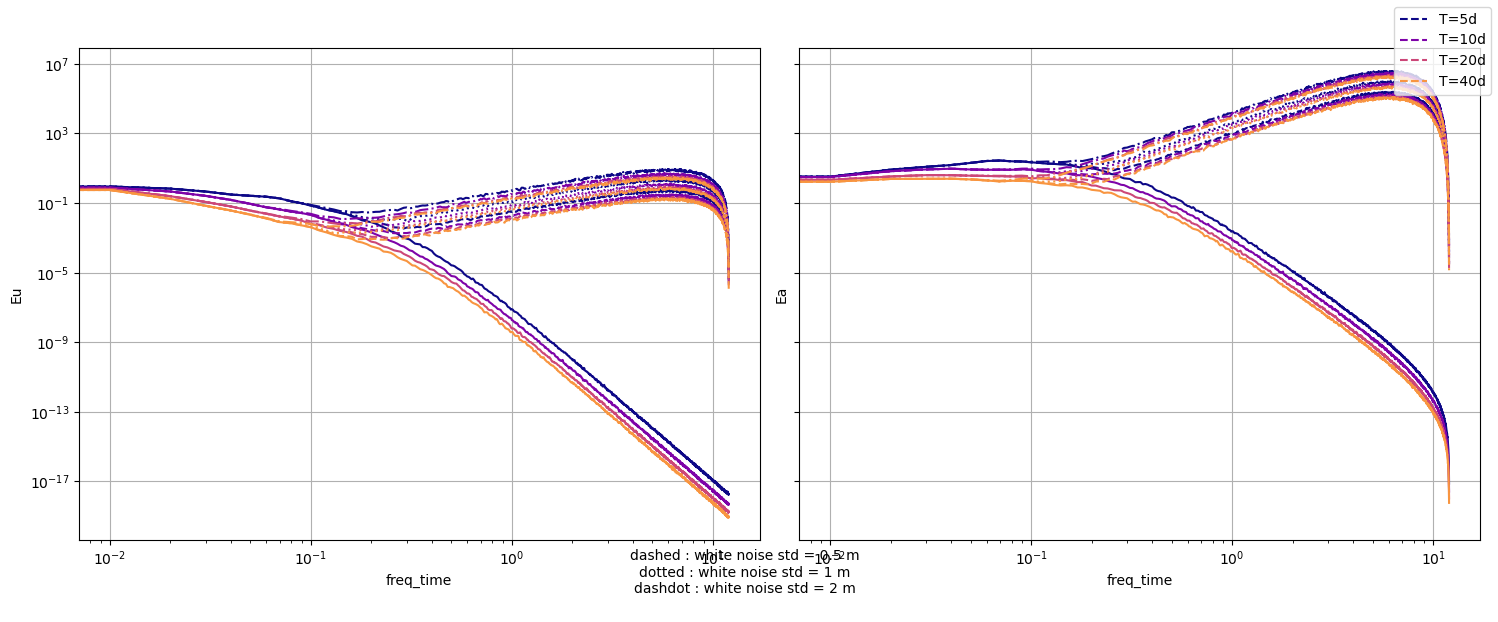

In [57]:
suffixes_ls = {'_nx05':'dashed','_nx1':'dotted', '_nx2' : 'dashdot', '': 'solid', }
suffixes_leg = { '_nx05':'white noise std = 0.5 m', '_nx1':'white noise std = 1 m', '_nx2':'white noise std = 2 m'}
plot_timeseries(ds.isel(draw=2), suffixes_ls=suffixes_ls, suffixes_leg=suffixes_leg);
plot_autocorrelations(ds.mean("draw"), tau_max=100, 
                      suffixes_ls = suffixes_ls, suffixes_leg = suffixes_leg);
plot_spectraloglog(ds, 
                   suffixes_ls = suffixes_ls,
                   suffixes_leg = suffixes_leg);

### On velocity

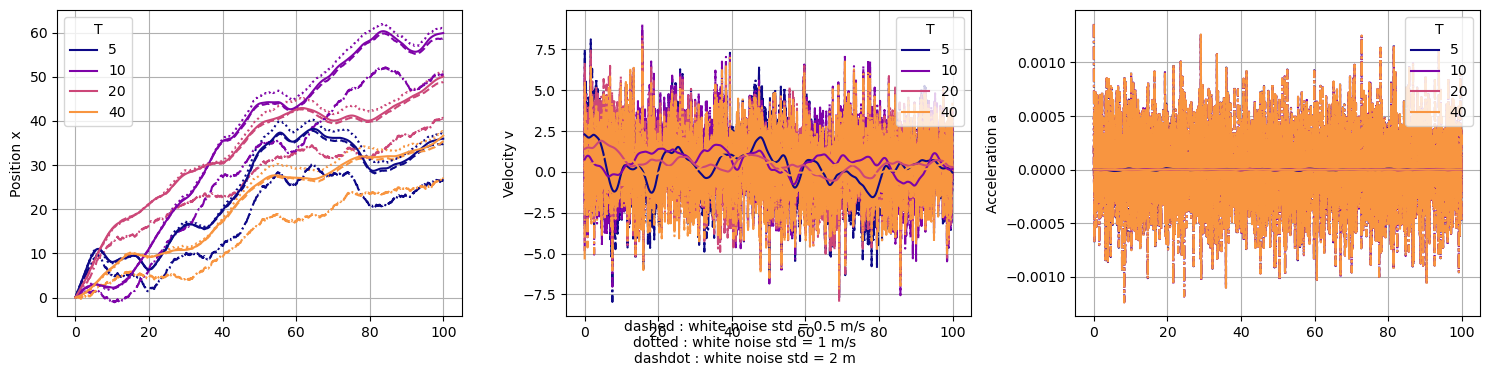

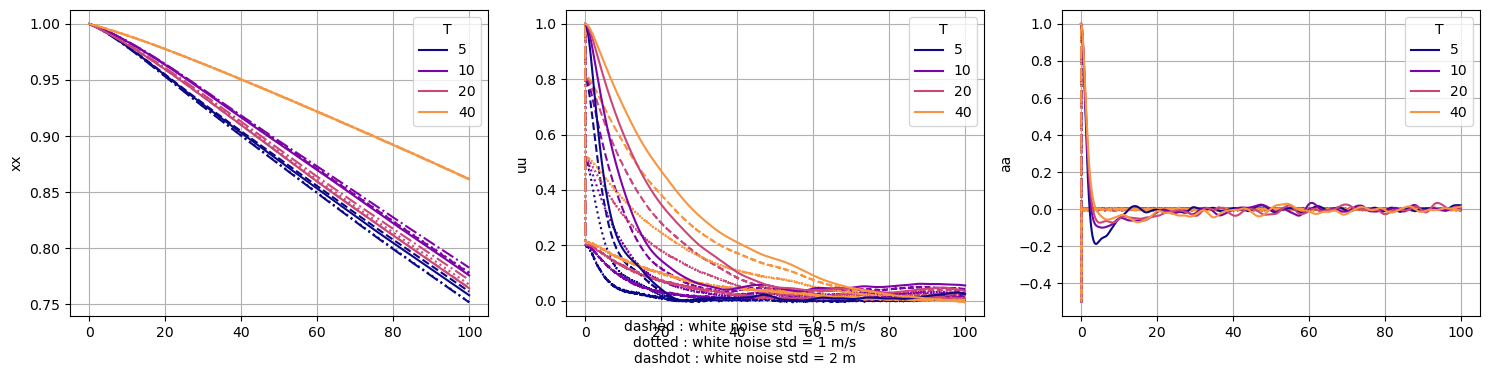

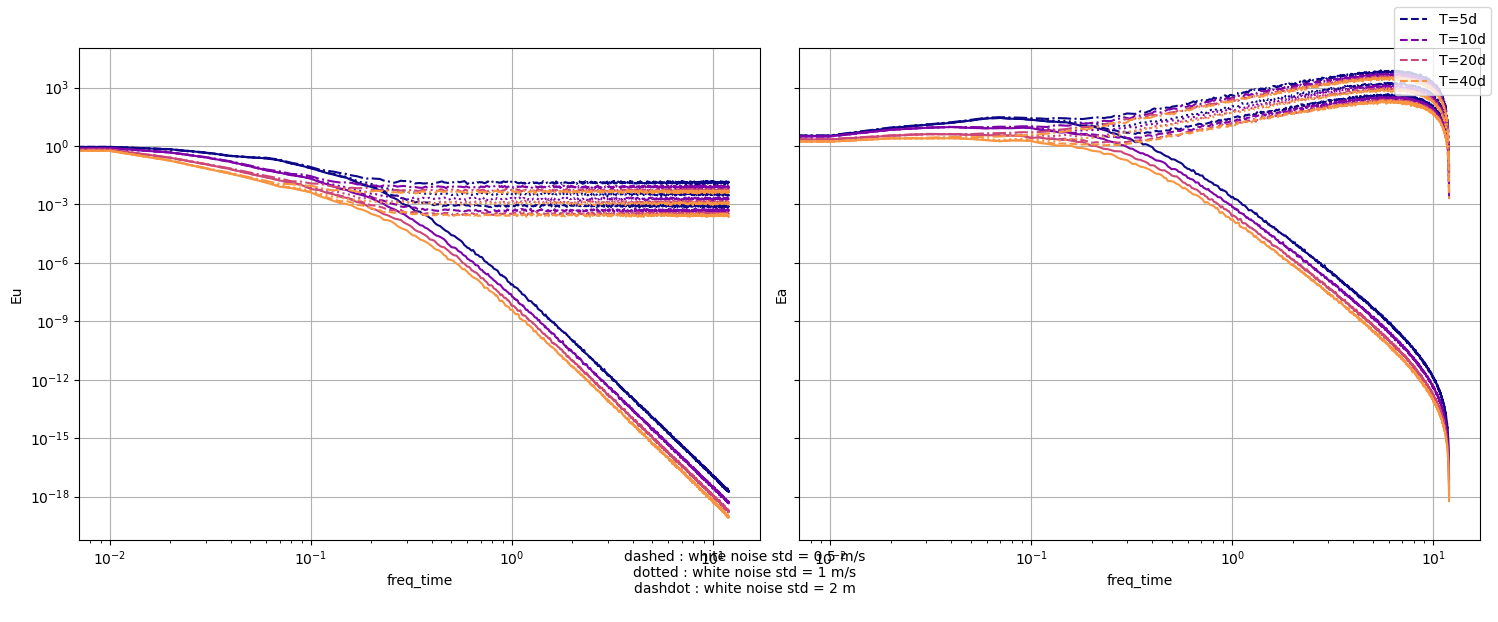

In [58]:
suffixes_ls = {'_nv05':'dashed','_nv1':'dotted', '_nv2' : 'dashdot', '': 'solid', }
suffixes_leg = { '_nv05':'white noise std = 0.5 m/s', '_nv1':'white noise std = 1 m/s', '_nv2':'white noise std = 2 m'}
plot_timeseries(ds.isel(draw=2), suffixes_ls=suffixes_ls, suffixes_leg=suffixes_leg);
plot_autocorrelations(ds.mean("draw"), tau_max=100, 
                      suffixes_ls = suffixes_ls, suffixes_leg = suffixes_leg);
plot_spectraloglog(ds, 
                   suffixes_ls = suffixes_ls,
                   suffixes_leg = suffixes_leg);